# Strategy for Lifting Non-Pharmaceutical Implementations
This notebook explores a decision support tool, which schedules the lifting of imposed restrictions. The basic idea is to only lift restrictions when a forward simulation guarantees that the load on the health-care system stays below a certain threshold.

The simulation is done by the Epidexus agent-based simulation engine. At certain intervals, the population is tested and a probabilistic estimator predicts the estimated mean and variance of the SEIR parameters.

## Setting up the Simulation
First we will set up a very simplified simulation with everybody in the same home location and empty itineraries. We will start out with 1000 people and infect the first 10.

In [1]:
from epidexus import EpidexusModel
from epidexus.world_creation import create_family

from datetime import datetime, timedelta
import numpy.random

start_date = datetime(2020, 3, 31)
sim_model = EpidexusModel(start_date, sim_time_step=timedelta(hours=1))
numpy.random.seed(0)

people, home_location = create_family(sim_model, 1000)
for i in range(10):
    people[i].infect()

initial_rate = 0.7
home_location.infection_rate = initial_rate

## Setup a Strategy
The strategy is just a list of the restriction value, with 0 being full restriction and 1 none. Each point in the strategy coresponds to one simulation tick (1 hour).

In [2]:
strategy = []
for i in range(10*24):
    strategy.append(1)
for i in range(30*24):
    strategy.append(1 - 2/3)
for i in range(20*24):
    strategy.append(1 - 1/3)
for i in range(30*24):
    strategy.append(1)

## Run the Simulation

In [3]:
for s in strategy:
    home_location.infection_rate = initial_rate * s
    sim_model.step()

## Plotting the output
Let's see if things look right. First the stackplot:

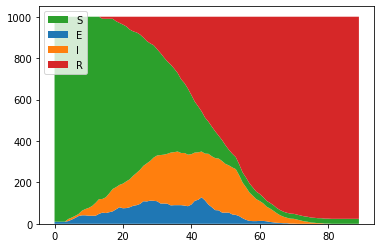

In [4]:
from epidexus.plotting import seir_stackplot, infected_plot
seir_stackplot(sim_model)


We will run a reference simulation with the same parameters but without the strategy enforced, and plot the two infected portions against each other:

In [5]:
sim_model_ref = EpidexusModel(start_date, sim_time_step=timedelta(hours=1))
numpy.random.seed(0)
people_ref, home_location_ref = create_family(sim_model_ref, 1000)
for i in range(10):
    people_ref[i].infect()
home_location_ref.infection_rate = initial_rate
for s in strategy:
    sim_model_ref.step()



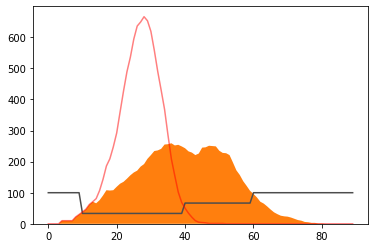

In [6]:
import matplotlib.pyplot as plt
ax = plt.subplot(1,1,1)
infected_plot(sim_model, ax=ax)
ax.plot([s*100 for s in strategy[::24]], '0.3')
seir_ref = sim_model_ref.datacollector.get_model_vars_dataframe()
ax.plot(seir_ref.axes[0], seir_ref["I"], 'r', alpha=0.5)

*Note that the implementation strategy has been scaled by 100.*